In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
cd /content/drive/MyDrive/Face_Mask/face-mask-detector

/content/drive/MyDrive/Face_Mask/face-mask-detector


In [ ]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/face-mask-detection/face-mask-detector.zip

In [ ]:
!unzip face-mask-detector.zip

In [39]:
# import các thư viện cần thiết
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tqdm import tqdm

In [17]:
# Đặt init learning rate, số epochs, batch_size
learning_rate = 1e-4
epochs = 20
batch_size = 32

In [28]:
# lấy list images từ thư mục dataset, sau đó khởi tạo
# list data(images,...) và class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []
# lặp qua các đường dẫn
print(imagePaths)
for imagePath in imagePaths:
	# lấy ra class label từ filename
	label = imagePath.split(os.path.sep)[-2]

	# load ảnh đầu vào(224x224) và xử lí
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image) #scale về [-1,1]

	# thêm vào data và labels list tương ứng
	data.append(image)
	labels.append(label)

# chuyển data và labels list sang Numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...
['dataset/with_mask/0-with-mask.jpg', 'dataset/with_mask/1-with-mask.jpg', 'dataset/with_mask/10-with-mask.jpg', 'dataset/with_mask/100-with-mask.jpg', 'dataset/with_mask/101-with-mask.jpg', 'dataset/with_mask/103-with-mask.jpg', 'dataset/with_mask/104-with-mask.jpg', 'dataset/with_mask/105-with-mask.jpg', 'dataset/with_mask/106-with-mask.jpg', 'dataset/with_mask/107-with-mask.jpg', 'dataset/with_mask/108-with-mask.jpg', 'dataset/with_mask/109-with-mask.jpg', 'dataset/with_mask/11-with-mask.jpg', 'dataset/with_mask/110-with-mask.jpg', 'dataset/with_mask/111-with-mask.jpg', 'dataset/with_mask/112-with-mask.jpg', 'dataset/with_mask/113-with-mask.jpg', 'dataset/with_mask/114-with-mask.jpg', 'dataset/with_mask/115-with-mask.jpg', 'dataset/with_mask/116-with-mask.jpg', 'dataset/with_mask/117-with-mask.jpg', 'dataset/with_mask/118-with-mask.jpg', 'dataset/with_mask/119-with-mask.jpg', 'dataset/with_mask/12-with-mask.jpg', 'dataset/with_mask/120-with-mask.jpg', 'datas

In [29]:
print(data.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376,)


In [30]:
# chuyển label sang dạng one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# chia tập data thành 80% tập train và 20% tập test
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# sinh thêm dữ liệu bằng data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [33]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(trainY)

(1100, 224, 224, 3) (1100, 2)
(276, 224, 224, 3) (276, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [46]:
# load MobileNetV2 network cho fine-tuning (bỏ đi head FC layer)
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# baseModel.summary()

# xây phần head của model (fine-tuning)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# đặt phần head vừa xây vào đầu của model load
model = Model(inputs=baseModel.input, outputs=headModel)
# model.summary()
# lặp qua các layer cơ sở của model MobileNetV2 và đóng băng để ko cập nhật hệ số những layer này
for layer in baseModel.layers:
  layer.trainable = False

In [47]:
# compile model
print("[INFO] compiling model...")
opt = Adam(lr=learning_rate, decay= learning_rate/EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
34/34 [==============================] - 45s 375ms/step - loss: 0.5309 - accuracy: 0.7875 - val_loss: 0.2528 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 11s 332ms/step - loss: 0.2426 - accuracy: 0.9616 - val_loss: 0.1307 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 11s 329ms/step - loss: 0.1456 - accuracy: 0.9785 - val_loss: 0.0839 - val_accuracy: 0.9855
Epoch 4/20
34/34 [==============================] - 12s 340ms/step - loss: 0.0952 - accuracy: 0.9860 - val_loss: 0.0604 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 12s 354ms/step - loss: 0.0765 - accuracy: 0.9860 - val_loss: 0.0476 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 12s 348ms/step - loss: 0.0589 - accuracy: 0.9934 - val_loss: 0.0389 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 12s 356ms/step - loss: 0.0433 - accuracy: 0.9972 - val_loss: 0.0326 - val_accuracy: 0.9928

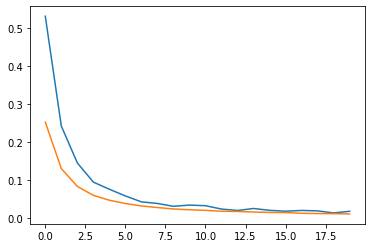

In [50]:
import matplotlib.pyplot as plt 

plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.show()

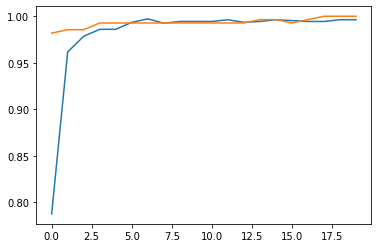

In [52]:
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.show()

In [53]:
model.save("face_mask.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
